In [ ]:
!pip3 install -qU boto3 

In [ ]:
import json
import os
import glob
import sys
import boto3
import base64
import requests
import time
import pprint
from datetime import datetime
from IPython.display import Image, display


In [ ]:
#get modelARN
region = 'us-east-1'#'us-west-2' #
boto3_bedrock = boto3.client('bedrock',region)
boto3_bedrock.list_foundation_models()

In [ ]:
!wget https://cats.com/wp-content/uploads/2020/10/tabby-maine-coon-768x384.jpg

In [ ]:
stream = False
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
#"modelId": "anthropic.claude-3-sonnet-20240229-v1:0"
# non streaming mode
def anthropic_claude_3(modelId,image_path,max_tokens,system_prompt):
    bedrock_runtime = boto3.client('bedrock-runtime')
    base64_image = encode_image(image_path)
    payload = {
        "modelId": modelId,
        "contentType": "application/json",
        "accept": "application/json",
        "body": {
            "anthropic_version": "bedrock-2023-05-31",
            "system": system_prompt,
            "max_tokens": max_tokens,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": base64_image
                            }
                        },
                        {
                            "type": "text",
                            #"text": "Write me a detailed description of these two photos, and then a poem talking about it."
                            "text": f"这是我审查的结果："
                        }
                    ]
                }
            ]
        }
    }
	
    # Convert the payload to bytes
    body_bytes = json.dumps(payload['body']).encode('utf-8')
	
    # Invoke the model
    response = bedrock_runtime.invoke_model(
        body=body_bytes,
        contentType=payload['contentType'],
        accept=payload['accept'],
        modelId=payload['modelId']
    )
	
    # Process the response
    response_body = json.loads(response['body'].read().decode('utf-8'))
    pprint.pprint(response_body)
    #return round(end-start,2),response_body["usage"]["input_tokens"],response_body["usage"]["output_tokens"]
    return round(float(response['ResponseMetadata']['HTTPHeaders']['x-amzn-bedrock-invocation-latency'])/1000,2),int(response['ResponseMetadata']['HTTPHeaders']['x-amzn-bedrock-input-token-count']),int(response['ResponseMetadata']['HTTPHeaders']['x-amzn-bedrock-output-token-count'])
	

In [ ]:
#"modelId": "anthropic.claude-3-sonnet-20240229-v1:0"
# streaming mode
def anthropic_claude_3_stream(modelId,image_path,max_tokens,system_prompt):
    bedrock_runtime = boto3.client('bedrock-runtime')
    base64_image = encode_image(image_path)
    payload = {
        "modelId": modelId,
        "contentType": "application/json",
        "accept": "application/json",
        "body": {
            "anthropic_version": "bedrock-2023-05-31",
            "system": system_prompt,
            "max_tokens": max_tokens,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": base64_image
                            }
                        },
                        {
                            "type": "text",
                            #"text": "Write me a detailed description of these two photos, and then a poem talking about it."
                            "text": f"这是我审查的结果："
                        }
                    ]
                }
            ],
            "temperature": 1,
            "top_p": 0.999,
            "top_k": 250,
"stop_sequences": ['\n\nHuman:']
        }
    }
	
    # Convert the payload to bytes
    body_bytes = json.dumps(payload['body']).encode('utf-8')
	
    # Invoke the model
    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body_bytes, modelId=payload['modelId'], accept=payload['accept'], contentType=payload['contentType']
    )
    stream = response.get('body')
    chunk_obj = {}
	
    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                pprint.pprint(chunk_obj)
	
    # Process the response
    #response_body = json.loads(response['body'].read().decode('utf-8'))
    #pprint.pprint(response_body)
    {'type': 'message_stop', 'amazon-bedrock-invocationMetrics': {'inputTokenCount': 92, 'outputTokenCount': 277, 'invocationLatency': 3679, 'firstByteLatency': 677}}
	
    return round(float(chunk_obj['amazon-bedrock-invocationMetrics']['firstByteLatency'])/1000,2),round(float(chunk_obj['amazon-bedrock-invocationMetrics']['invocationLatency'])/1000,2),chunk_obj['amazon-bedrock-invocationMetrics']['inputTokenCount'],chunk_obj['amazon-bedrock-invocationMetrics']['outputTokenCount']

In [83]:
# 调用结果
image_path = "tabby-maine-coon-768x384.jpg"
max_tokens = 200
system = """你是一个图片审核的AI专家，你需要协助人类进行图片审核的工作，你审核图片的标准如下
1. 图片需要是真人，女生，五官清晰，五官端正，图片包含有完整的脸部内容，
2. 图片不能够只露出眼睛，不能带面罩和口罩
2. 图片不能是动漫风格、不能男女混合（不能出现男性）、不能出现小孩、不能是纯风景
3. 图片不能太小，也就是图片的分辨率要高，同时尺寸不能小于480*768
4. 图片除非裸露了胸部和下体才可以判定为不通过，如果只是露出肩膀，露出肚脐，露出大腿和小腿这些都属于可以判定为通过，也就是整体构图不露骨就可以通过
5. 图片严禁涉及血腥、政治的题材，但是如果只是穿着和宗教风俗有关的衣服，其他方面没有问题，应该判为通过
你的输出请按照下面的json格式给出,如果不通过，请给出原因:
{ "结果" = "通过" or "不通过",
  "图片描述" = "xxxxxx",
  "不通过的原因" = "xxxx"
}
"""

In [ ]:
#haiku
print("Haiku:")
modelId = "anthropic.claude-3-haiku-20240307-v1:0"


In [ ]:
print(anthropic_claude_3(modelId,image_path,max_tokens,system))

In [ ]:
print(anthropic_claude_3_stream(modelId,image_path,max_tokens,system))	

In [74]:
#sonnet
print("Sonnet:")
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"


Sonnet:


In [ ]:
print(anthropic_claude_3(modelId,image_path,max_tokens,system))

In [ ]:
print(anthropic_claude_3_stream(modelId,image_path,max_tokens,system))		

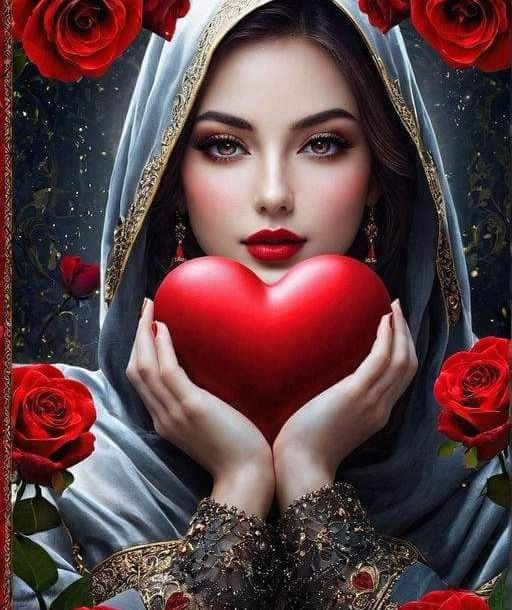

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这是一张艺术创作的数字插画,画面中的人物是一位长相美丽的女子,她身穿银灰色的头纱和精美的礼服,双手捧着一颗红色的心形物体,周围环绕着大量的红色玫瑰花。画面色彩鲜艳,充满浪漫和神秘色彩。",\n'
                      '  "不通过原因": '
                      '"根据您提供的审核标准,这张图片属于动漫风格的艺术创作,不符合真人照片的要求,因此无法通过审核。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01Ltuukj7Gu9FxsvASm9srMJ',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 878, 'output_tokens': 199}}
(7.55, 878, 199)


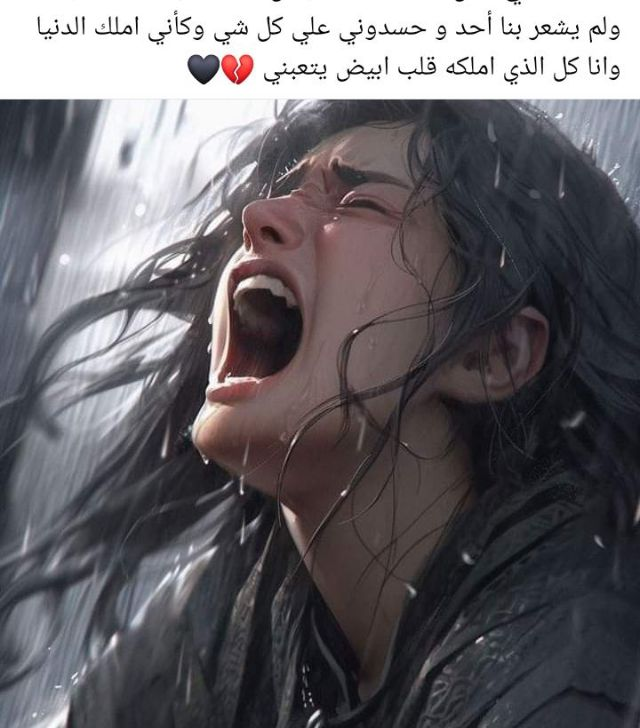

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图像是一幅艺术插画,描绘了一位年轻女子在暴雨中大声呼喊的场景。她有着乌黑的长发,表情极为痛苦绝望,仿佛在经历某种巨大的悲伤。虽然这是一幅优秀的艺术作品,但它不符合真人女性图像的要求。",\n'
                      '  "不通过的原因": "这是一幅艺术插画,而非真人照片,因此不符合图片审核的标准。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01EUCRnHWsvNEYm9MrdQhqhq',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1058, 'output_tokens': 185}}
(5.02, 1058, 185)


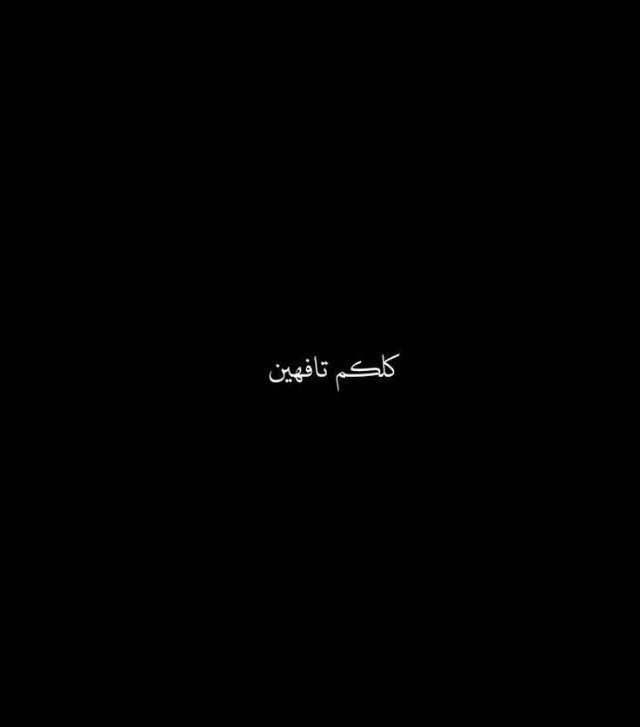

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这是一张纯黑色的背景图片,中间有用阿拉伯文书写的"Coke '
                      'Navidson"文字。",\n'
                      '  "不通过的原因": '
                      '"该图片不包含任何真人的形象,因此不符合要求。图片审核的标准是图片需要包含真人女性的五官和面部特征。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_019TeyNZUbPxdfWwavuV1wsR',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1058, 'output_tokens': 129}}
(5.1, 1058, 129)


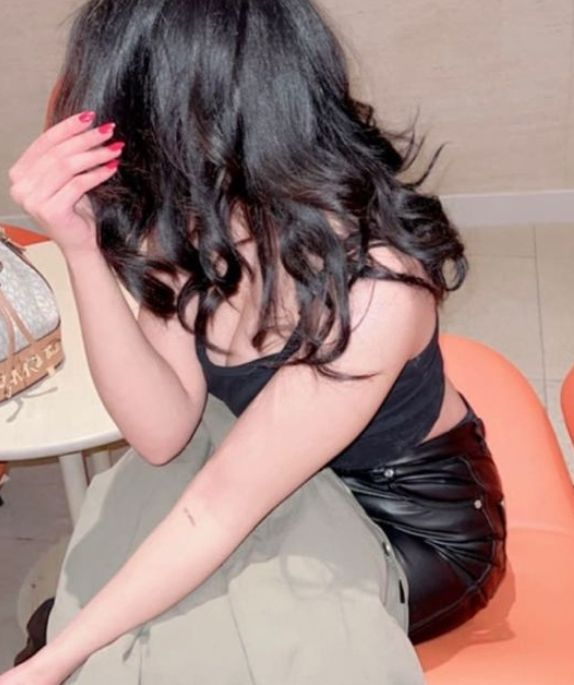

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "图片中有一位女性,长发披肩,她用双手遮挡着脸部,看不清五官,穿着一件黑色上衣。",\n'
                      '  "不通过的原因": '
                      '"由于人物用手遮挡了脸部,无法清晰看到五官,不符合审核要求中\'五官清晰\'的标准。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01L5avppPWs1r9rdC9pAa3mY',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 985, 'output_tokens': 129}}
(4.71, 985, 129)


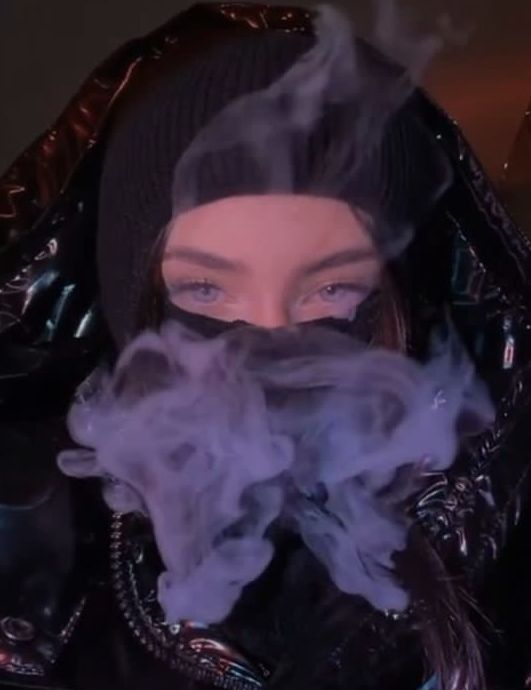

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片展示了一位女性戴着黑色头巾,只露出了眼睛和嘴巴部分,其他部分被蓝色烟雾遮挡。整体画面有一种神秘感。",\n'
                      '  "不通过原因": '
                      '"虽然图片展现了一位真人女性,但因为大部分面部被烟雾遮挡,无法清晰看到五官,也无法判断面部是否端正,因此不符合图片审核标准中的要求。另外,部分面部被遮挡也违反了不能戴面罩的规定。"',
              'type': 'text'}],
 'id': 'msg_01EmDN74s2UJuauP233azqk1',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'max_tokens',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 935, 'output_tokens': 200}}
(6.99, 935, 200)


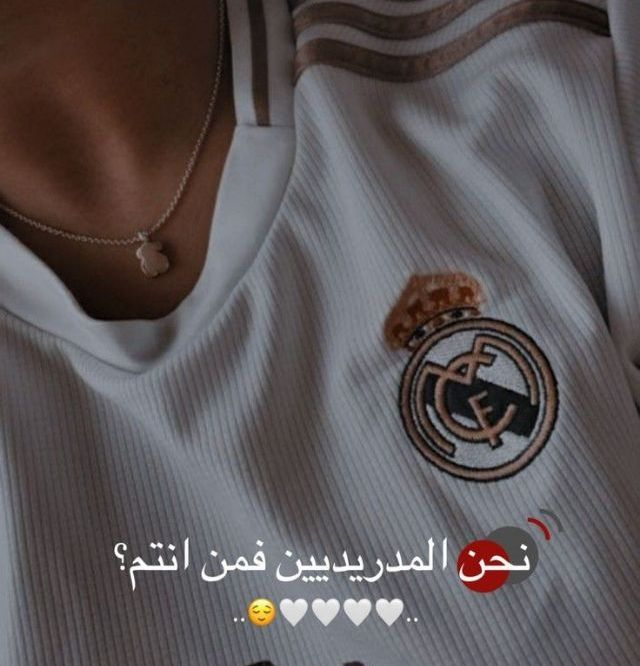

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"该图像展示了一件白色球衣的细节,上面印有皇家马德里足球俱乐部的标志,同时还有一条项链。照片上还有一些阿拉伯语的文字。",\n'
                      '  "不通过的原因": '
                      '"该图片不是一张真人女性的头像照片,因此不符合审核要求。此外,图片中含有球队标志和文字内容,可能存在侵权问题。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01BqncVgucyfXxGb8mJaWTBa',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1012, 'output_tokens': 159}}
(8.81, 1012, 159)


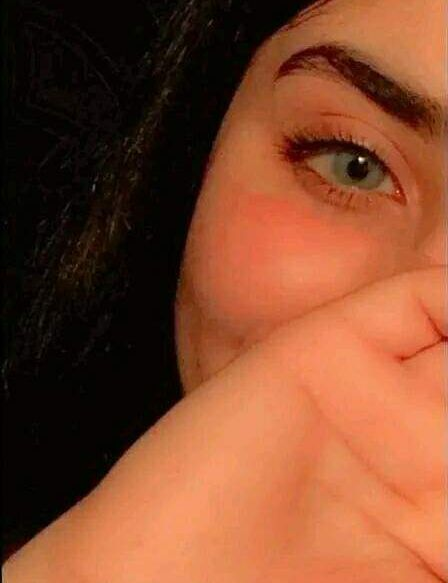

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这张图片是一位女性的特写镜头,只能看到她的眼睛和部分面部轮廓。",\n'
                      '  "不通过的原因": '
                      '"图片仅仅露出了眼睛,没有完整展示五官和整张脸部,不符合要求。此外,分辨率较低,整体画面细节不够清晰。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01BDeTBDaA6XLGfEdk3HBSj4',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 796, 'output_tokens': 132}}
(3.06, 796, 132)


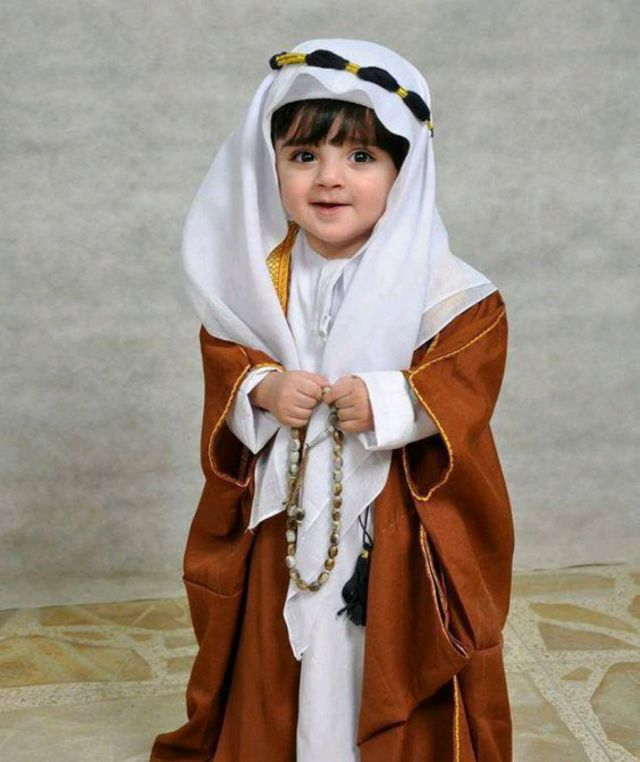

{'content': [{'text': '{\n'
                      '"结果": "不通过",\n'
                      '"图片描述": '
                      '"这张图片展示了一个身穿棕色长袍及头巾的小女孩,她面带微笑,双手合十,似乎在表演某种角色扮演。",\n'
                      '"不通过的原因": "根据您提供的审核标准,这张图片不能通过,原因是图像中出现了小孩。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_017cXS4UokBNsthcbYuAv8Lg',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1104, 'output_tokens': 123}}
(4.09, 1104, 123)


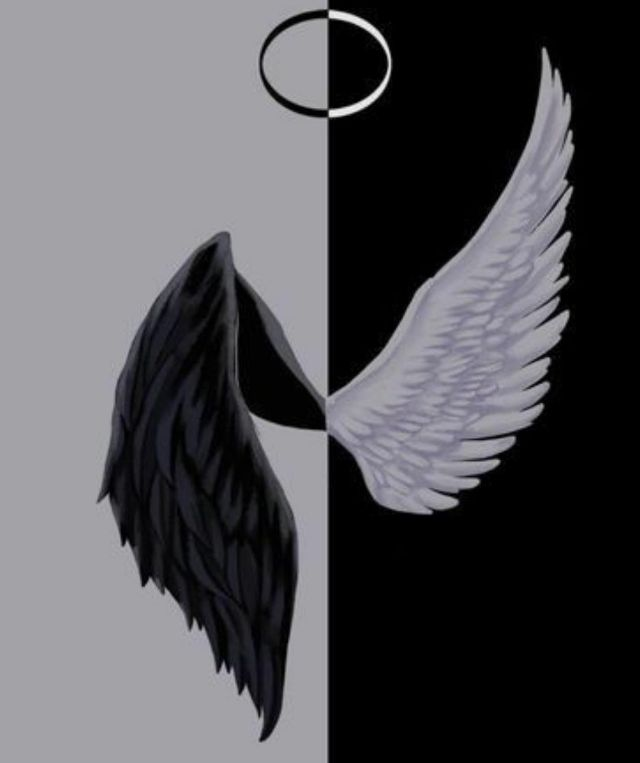

{'content': [{'text': '{\n'
                      '"结果": "不通过",\n'
                      '"图片描述": '
                      '"这是一幅黑白色的插画图像,图中有一对黑色和白色的翅膀悬挂在一个装饰性的圆环上。整体场景简单、抽象,没有出现真人。",\n'
                      '"不通过原因": "该图像不是真人照片,而是一幅抽象的插画作品,因此不符合真人女性照片的要求。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01Tk4CjcB6KiVHCCoiwj1qEJ',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1104, 'output_tokens': 140}}
(4.72, 1104, 140)


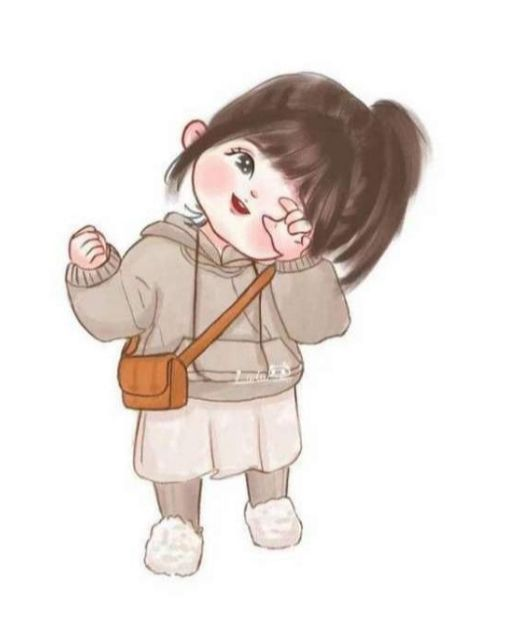

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这是一张动漫风格的插画作品,画的是一个穿着厚实冬衣的小女孩卡通形象。",\n'
                      '  "不通过的原因": "根据您提供的审核标准,这张图片不符合要求,因为它是动漫风格的作品,而非真人照片。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01UH1Aw8e2zNzhU1e5bEx2dp',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 897, 'output_tokens': 121}}
(2.73, 897, 121)


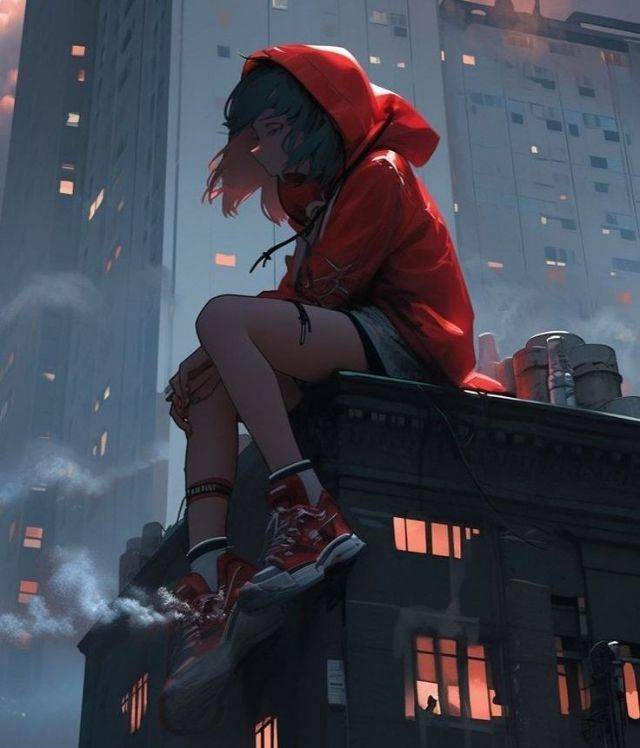

{'content': [{'text': '{\n'
                      '  "结果": "不通过", \n'
                      '  "图片描述": '
                      '"这张图片是一位红色帽衫女孩坐在城市建筑物的边缘,身后是一座城市的高楼大厦。画风属于动漫或者插画风格,并非真实人像摄影作品。",\n'
                      '  "不通过的原因": '
                      '"图片属于动漫或者插画风格,而非真实的人物肖像照片,因此不符合您提出的图片审核标准。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01KU9zXqSHpE4UgK5VnJSHLX',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1081, 'output_tokens': 154}}
(5.6, 1081, 154)


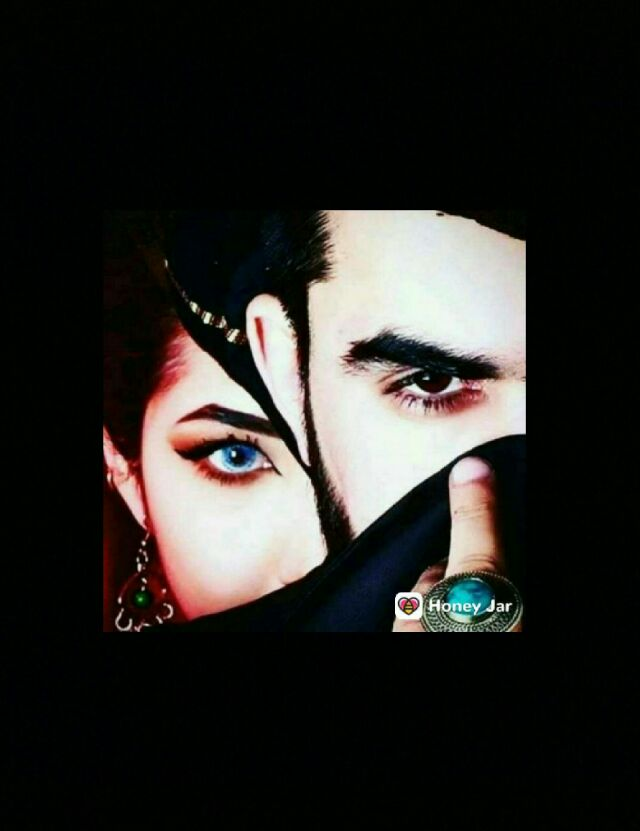

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这张图片是一个男女情侣合影,只露出了他们的眼睛和一部分面部轮廓。",\n'
                      '  "不通过的原因": '
                      '"这张图片虽然展现了情侣之间的亲密互动,但是只露出了部分面部,无法看清楚完整的五官和面容,不符合要求中人物要五官清晰、完整脸部的标准。此外,图片也混合了男女两性,不符合单一性别的要求。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01UZm8nJ7U2As5ZUBwXEp5rU',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1150, 'output_tokens': 173}}
(5.42, 1150, 173)


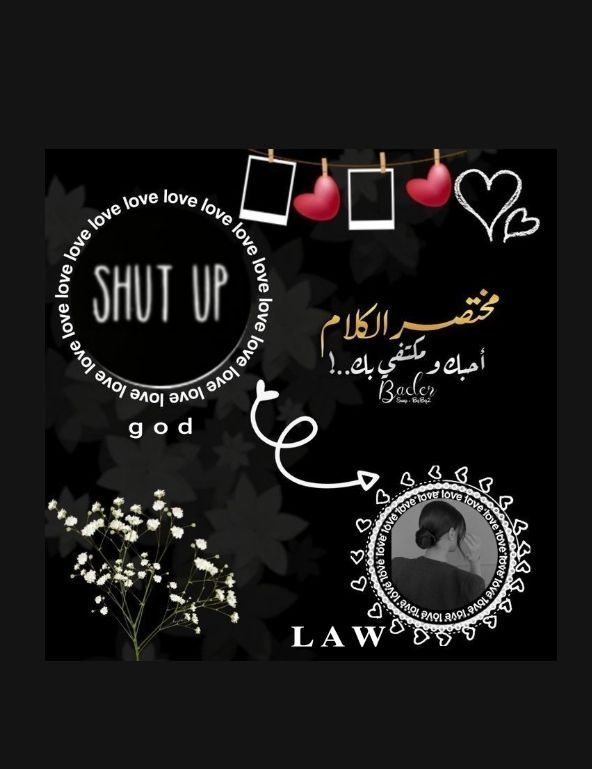

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片是一个黑色背景上的复合图像,包含了一些浪漫元素如爱心、小黑板等,还有一些阿拉伯语的书写。整体设计具有抽象和装饰风格。",\n'
                      '  "不通过原因": '
                      '"该图像不符合真人女性肖像的要求,而是一个设计作品。它缺乏完整的人物形象和清晰可辨的五官特征。根据给定的审核标准,此图像被判定为不通过。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01AJjuKbHw3ciipE6q6hH5dP',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1076, 'output_tokens': 182}}
(7.51, 1076, 182)


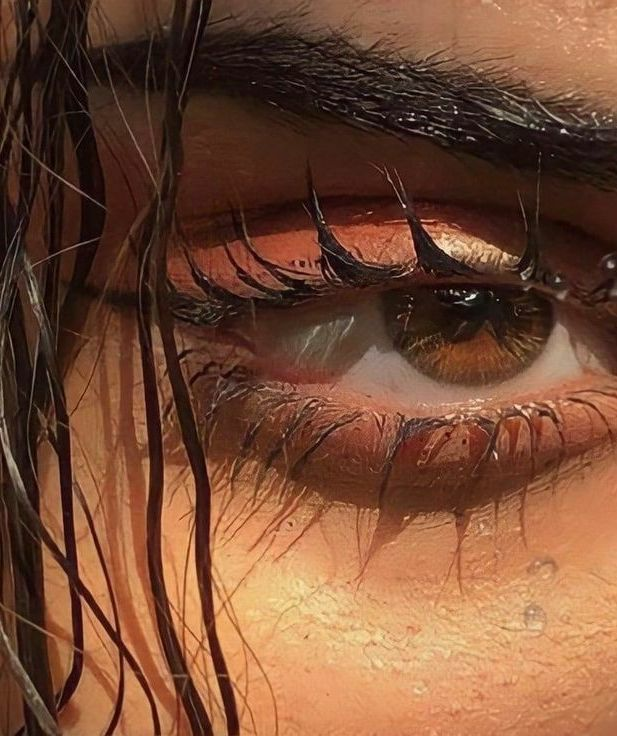

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这是一张特写的人眼图片,眼睛的细节非常清晰,画面质量很高。",\n'
                      '  "不通过的原因": '
                      '"根据提供的审核标准,该图片虽然细节精细,但只有眼部特写,缺少完整的五官和脸部信息,因此不符合要求。图片需要展现完整的真人女性面部五官才能通过审核。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01CNXyCycFL6o8V92imRLDHH',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1081, 'output_tokens': 149}}
(7.1, 1081, 149)


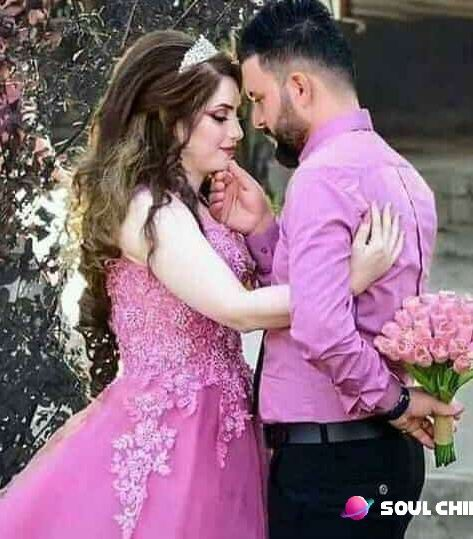

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片显示一对情侣在拥抱彼此,身穿盛装,男士手捧一束鲜花。他们的动作亲密无间,似乎是在庆祝某种重大场合。",\n'
                      '  "不通过的原因": '
                      '"图片中出现了男性,根据您提供的审核标准,图片中不能有男性出现,因此该图片不通过审核。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01ArZaH6fgoS2Wheqb2aqaEw',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 800, 'output_tokens': 147}}
(3.88, 800, 147)


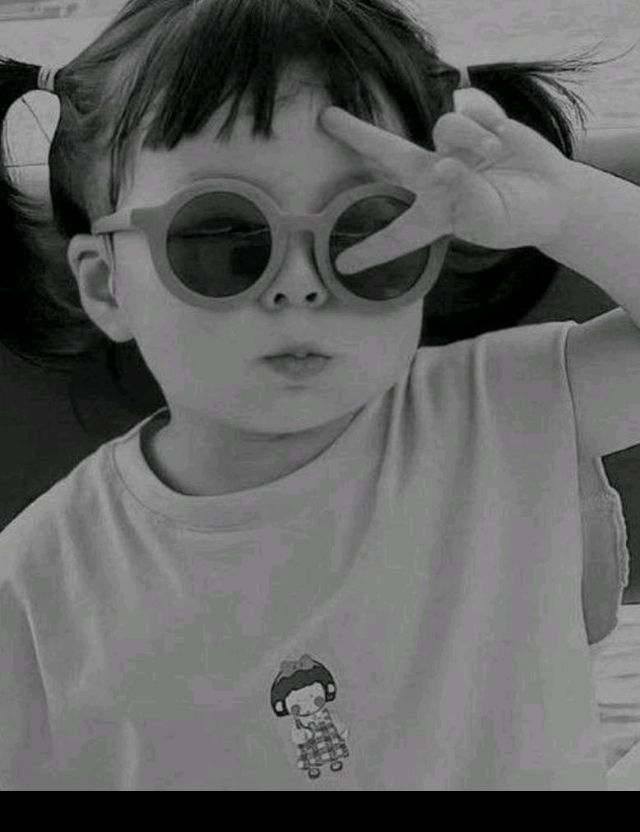

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张黑白照片展示了一个小孩正在戴着一副夸张的大眼镜,透过镜片可以看到孩子的双眼。孩子穿着一件印有小人物图案的T恤衫。",\n'
                      '  "不通过的原因": '
                      '"根据您提供的审核标准,这张图片不符合要求,原因如下:1.图中出现了小孩,而非成年女性。2.图片分辨率较低,素质不高。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_015TRU7CQkr5fJz9Fx5KvaJX',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1150, 'output_tokens': 170}}
(4.34, 1150, 170)


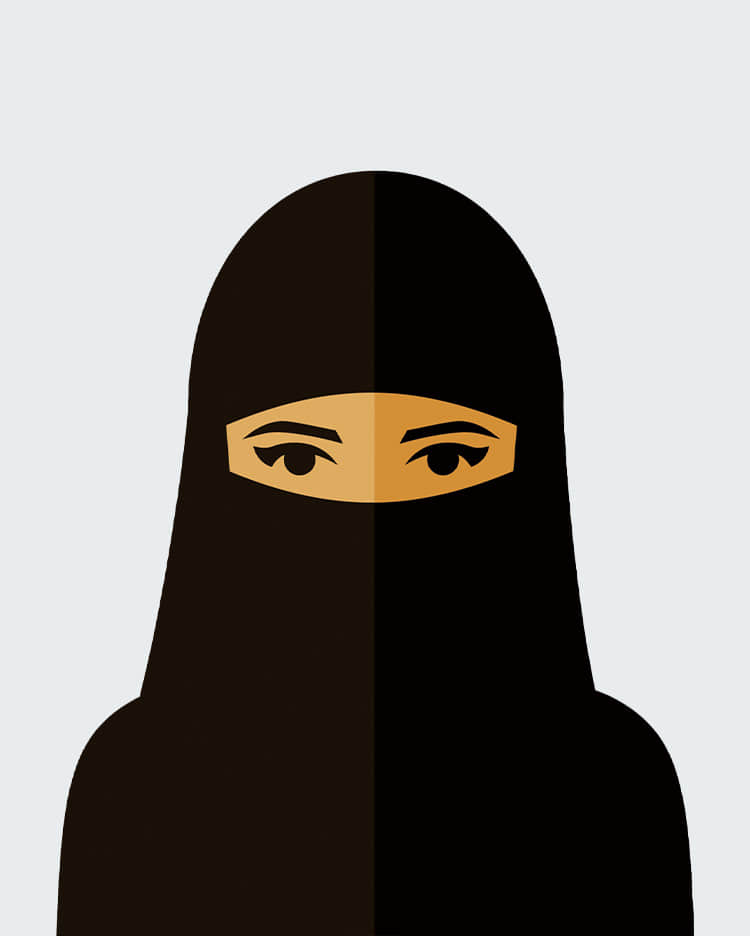

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片是一个穆斯林妇女戴面纱的简单插画。只能看到她的眼睛,其余部分被黑色面纱遮盖。",\n'
                      '  "不通过的原因": '
                      '"根据您提供的审核标准,这张图片不符合要求,因为图片中的人戴着面罩遮盖了面部。审核标准明确指出,图片不能带面罩或口罩。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01XKpYYyqgKeMoCNMZ7wJEk7',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1378, 'output_tokens': 156}}
(4.98, 1378, 156)


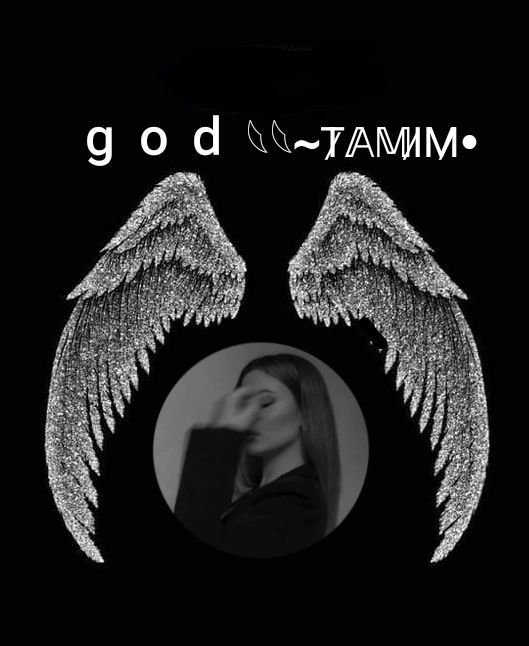

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这张图片是黑色背景,上面有一对翅膀的图案,中间是一个戴着黑色头纱的女性半身像。",\n'
                      '  "不通过的原因": '
                      '"该图像包含一些宗教元素,如女性头纱和翅膀图案,可能与特定宗教文化有关。根据审查标准,如果构图不露骨且不涉及政治或血腥内容,含有风俗宗教元素是可以通过的。但该图像的整体氛围较为阴暗,给人以一种神秘而沉重的感觉,可能',
              'type': 'text'}],
 'id': 'msg_01TaJnR5Zdkshn7WYCi1GEe9',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'max_tokens',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 916, 'output_tokens': 200}}
(6.0, 916, 200)


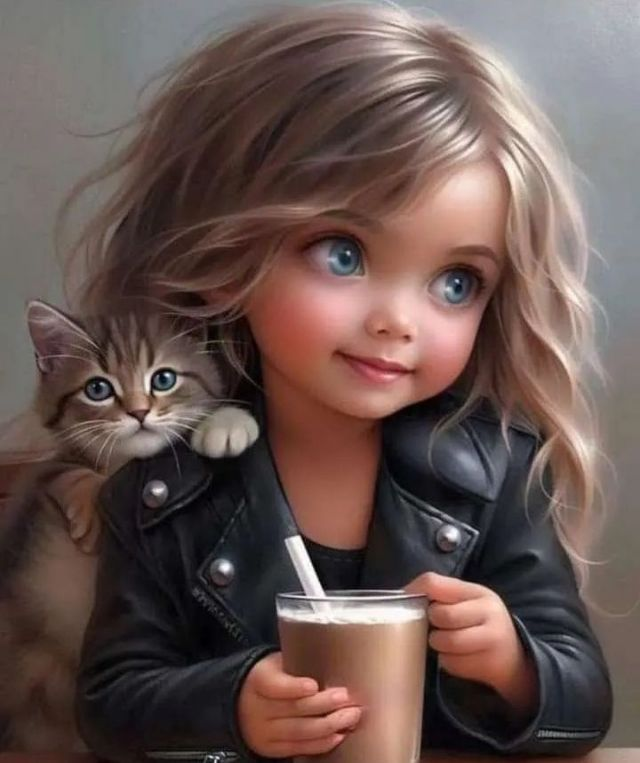

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片是一张艺术插画,描绘了一个戴着皮夹克的卡通女孩,手里抱着一只猫,正在喝热饮料。",\n'
                      '  "不通过的原因": "这张图片不是真人照片,而是卡通风格的艺术品,所以不符合真人女性肖像的要求。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01BfQymREbnPj1ZYKt8Xu982',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1104, 'output_tokens': 133}}
(7.88, 1104, 133)


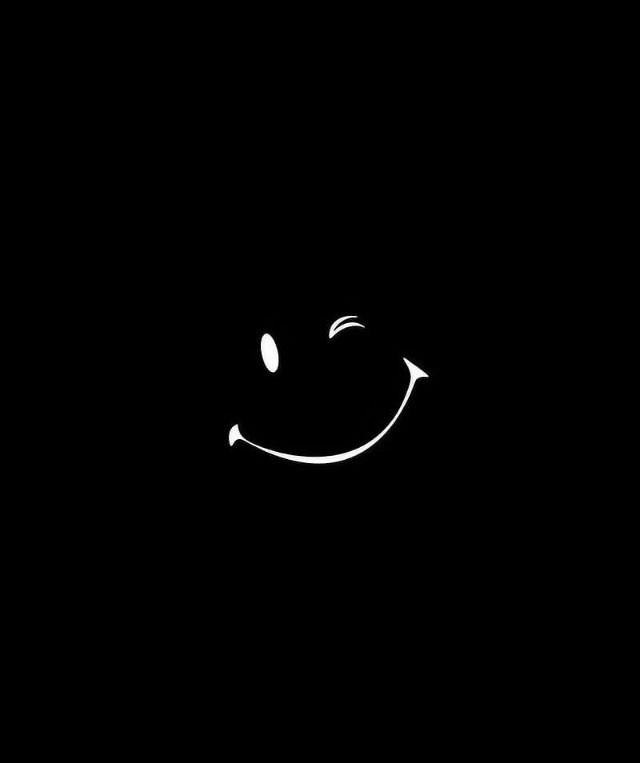

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": "这是一个黑色背景上的简单笑脸图案,没有真人出现。",\n'
                      '  "不通过原因": '
                      '"图片不符合要求,因为它不是真人图像,而是一个简单的表情符号图案。根据给定的审核标准,图片需要展示真人女性的完整脸部特写。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_018CbJ92v66319GQ2EvtdCGr',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1104, 'output_tokens': 126}}
(3.79, 1104, 126)


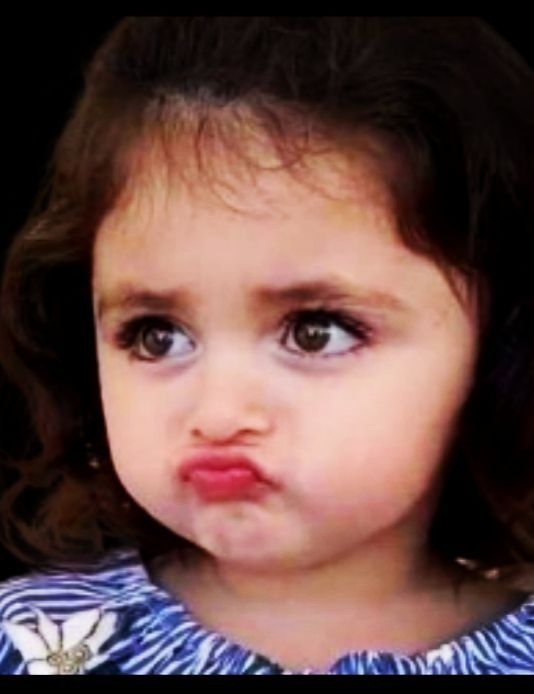

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片是一个卷发小女孩的特写照片,她有着大大的眼睛和鼓着的小嘴。照片中只有她的脸部可见,看起来有些生气或不高兴的表情。",\n'
                      '  "不通过的原因": '
                      '"根据你提供的审核标准,这张图片不符合要求,因为它是一个小女孩的照片,而不是成年女性。审核要求明确规定了图片必须是成年真人女性。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01A7UhXM5Av9R7t8YddboGZA',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 960, 'output_tokens': 173}}
(5.12, 960, 173)


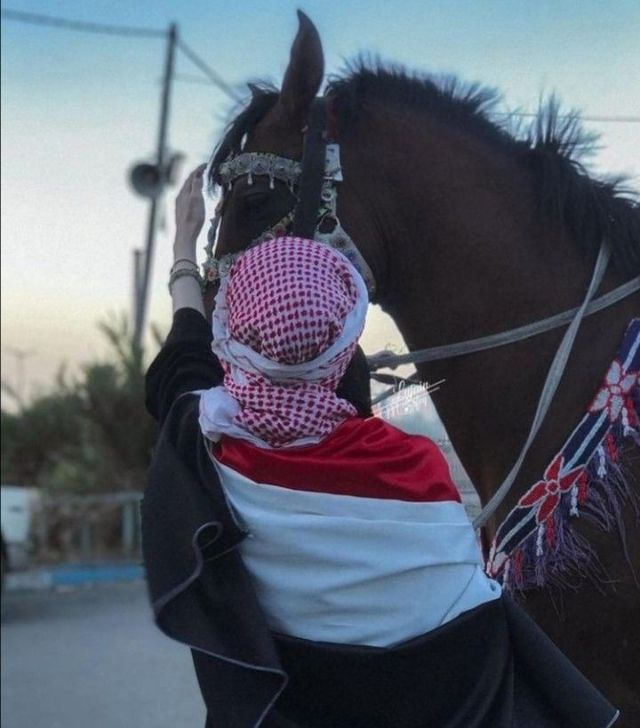

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片展示了一个骑着黑马的人,他戴着挡面的头巾和标志性的红白相间头巾,背景是日落时分的乡村风景。",\n'
                      '  "不通过的原因": "根据您提供的标准,这张图片涉及了政治相关的内容,因此不符合审核要求。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01DgoXhVLfwJHGSfviKwNQ5e',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1058, 'output_tokens': 130}}
(5.39, 1058, 130)


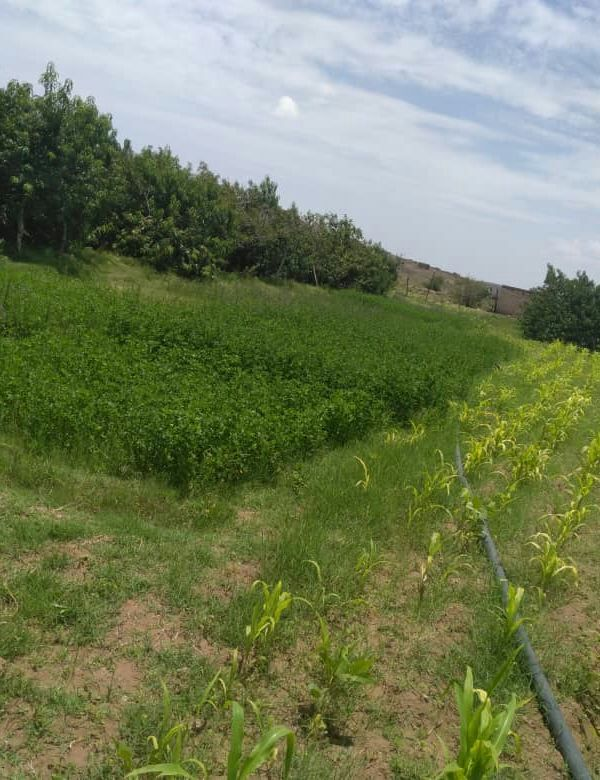

{'content': [{'text': '{ \n'
                      '  "结果" = "不通过",\n'
                      '  "图片描述" = '
                      '"这张图片显示了一片绿色植被茂盛的田野,远处有一片树林和略微多云的天空。图片中没有人物出现。",\n'
                      '  "不通过的原因" = "该图片不包含所需的真人女性人像内容,只是一个纯风景的图片。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01JMMXxD8AyUnkTTDSYvbWef',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1076, 'output_tokens': 121}}
(4.31, 1076, 121)


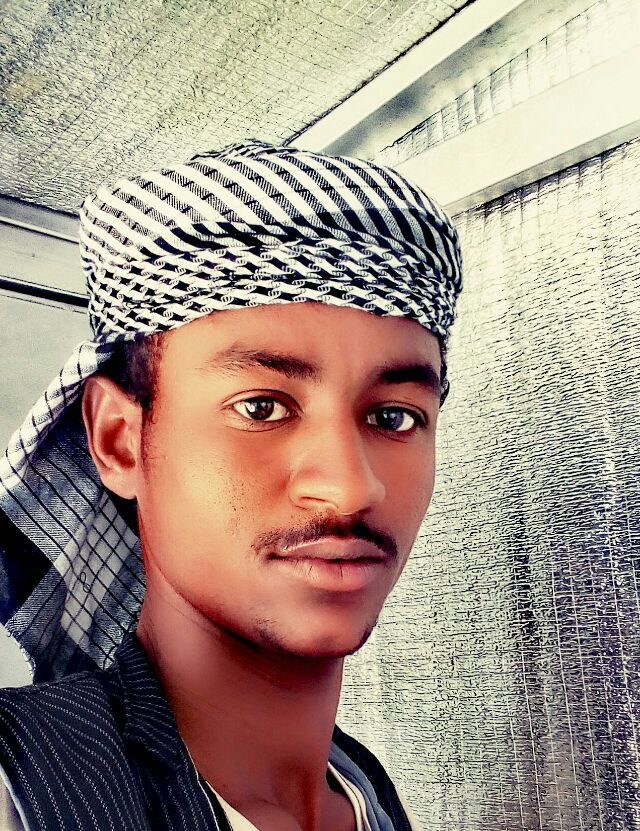

{'content': [{'text': '{\n'
                      '  "结果": "不通过",\n'
                      '  "图片描述": '
                      '"这张图片是一名戴着传统阿拉伯头巾的年轻男子的自拍照,他有一双明亮的眼睛和稀疏的胡须。背景是一堵砖墙。",\n'
                      '  "不通过的原因": '
                      '"根据您提供的审核标准,该图片不符合要求,原因是:这张图片是一名男性的半身像,而非要求的真人女性肖像。"\n'
                      '}',
              'type': 'text'}],
 'id': 'msg_01LsAS8GRF7tZcWwi4bpCGGG',
 'model': 'claude-3-sonnet-28k-20240229',
 'role': 'assistant',
 'stop_reason': 'end_turn',
 'stop_sequence': None,
 'type': 'message',
 'usage': {'input_tokens': 1150, 'output_tokens': 156}}
(4.44, 1150, 156)


In [85]:
# 指定你的图片目录路径
directory_path = 'zhubo_moment_pics/disqualified'
# 创建图片文件的完整路径模式
pattern = os.path.join(directory_path, '*.jpg')

# 使用glob找到所有的.jpg文件
image_files = glob.glob(pattern)

# 如果没有找到文件，打印消息
if not image_files:
    print("No defined pattern files found in the directory.")
else:
    # 打印每一个文件的路径
    for image_file in image_files:
        display(Image(filename=image_file))
        print(anthropic_claude_3(modelId,image_file,max_tokens,system))
